<a href="https://colab.research.google.com/github/mckhannacademy/Stats-112-Final-Project/blob/main/Final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning

In [2]:
import pandas as pd

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')
data_dir = "/content/gdrive/My Drive/csv_files/"

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(data_dir + "CombinedPremData.csv")
df_train = df[df["fifa_version"] < 23].copy()
df_test = df[df["fifa_version"] == 23].copy()

For training and testing data, I will use the most recent season as testing data and the other four seasons as training data. The specific features I will use are Progressive Passes, Interceptions, Tackles, Challenges, Blocks, Goals, Assists, Position, Minutes Played (divided by 90), and Progressive Carries

In [5]:
X_train = df_train[["PrgPper90", "Tklsper90", "Intsper90", "Chlgsper90", "Blocksper90",
             "Gls.1", "Ast.1", "Pos", "90s", "PrgCper90"]]
y_train = df_train["overall"]
X_test = df_test[["PrgPper90", "Tklsper90", "Intsper90", "Chlgsper90", "Blocksper90",
             "Gls.1", "Ast.1", "Pos", "90s", "PrgCper90"]]

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import randint, loguniform
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import math

First, as a baseline, I would like to train a K-Nearest Neighbors model. To tune this, I will be running a for loop that tracks the mean squared error at each spot. As seen in the graph below, the optimal number of neighbors is 19, which has a value around 10.1

<Axes: >

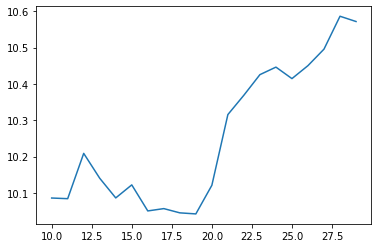

In [8]:
ks, test_mses = range(10, 30), []
for k in ks:
  pipeline_k = make_pipeline(
      ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
      KNeighborsRegressor(n_neighbors=k))
  test_mses.append(-cross_val_score(
      pipeline_k, X_train, y_train,
      scoring="neg_mean_squared_error", cv=10).mean())
pd.Series(test_mses, index=ks).plot.line()


Since the K-Nearest Neighbors model is still a little far from the error I want, I will be trying some more advanced models. The first is an MLP Regressor. For each of these models I will be tuning using a Randomized Search. (In case you are curious, I tried to run a Grid Search and my computer crashed, so I decided to opt for a random search in the interest of time at the expense of accuracy).

*Note: Because of an issue I am running the Randomized Search for the MLP Regressor again following my analysis. As a result, the parameters returned may very likely be different than the ones I used in my model. For the record, the parameters currently in "pipeline_mlp" are the original parameters returned by the random search*


In [11]:
pipeline = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    MLPRegressor())



In [12]:
param_dist = {"mlpregressor__hidden_layer_sizes": [(50,), (100,), (150,),
                                                   (200,), (250,), (100, 50), 
                                                   (50, 50)],
              "mlpregressor__activation": ['identity', 'logistic', 
                                           'tanh', 'relu'],
              "mlpregressor__solver": ['lbfgs', 'sgd', 'adam'],
              "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
              "mlpregressor__learning_rate": ['constant', 'invscaling', 
                                              'adaptive']}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                                   n_iter=10, cv=10, 
                                   scoring='neg_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and negative MSE
print("Best parameters: ", random_search.best_params_)
print("Negative MSE: ", random_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Best parameters:  {'mlpregressor__solver': 'adam', 'mlpregressor__learning_rate': 'invscaling', 'mlpregressor__hidden_layer_sizes': (50, 50), 'mlpregressor__alpha': 0.001, 'mlpregressor__activation': 'identity'}
Negative MSE:  -9.497382696826286


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
pipeline_mlp = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    MLPRegressor(activation = "tanh", alpha = 0.0001, hidden_layer_sizes = (100,), 
                 learning_rate = "adaptive", solver = "sgd"))


To evaluate the models at the end, I will be storing each model (eventually) within a DataFrame

In [242]:
# Note: idea of storing model performance in dataframe was inspired by Figure 
# Skating example given on course website
model_error = {
    "Model" : [],
    "Cross-Validation RMSE" : [],
    "Test Error RMSE" : [],
}


In [243]:
scores = cross_val_score(pipeline_mlp, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

pipeline_mlp.fit(X=X_train, y=y_train)
results = pipeline_mlp.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("MLP Regressor")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [99]:
model_error

{'Model': ['MLP Regressor'],
 'Cross-Validation RSME': [3.1430227305059084],
 'Test Error RSME': [2.9188082069733357]}

For the second model, I will be using a RandomForestRegressor, which will be tuned in the same way as the MLP Regressor and saved (following tuning) as "pipeline_rf"

In [6]:
pipeline2 = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    RandomForestRegressor())



In [62]:
param_dist = {
    "randomforestregressor__n_estimators": np.arange(100, 1001, 100),
    "randomforestregressor__max_depth": [5, 10, 15, None],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__min_samples_leaf": [1, 2, 4],
    "randomforestregressor__max_features": ["sqrt", "log2", None],
    "randomforestregressor__bootstrap": [True, False],
}

random_search = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist, 
                                   n_iter=10, cv=10, scoring='neg_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and negative MSE
print("Best parameters: ", random_search.best_params_)
print("Negative MSE: ", random_search.best_score_)

Best parameters:  {'randomforestregressor__n_estimators': 700, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': None, 'randomforestregressor__bootstrap': False}
Negative MSE:  -9.16461450762305


In [63]:
pipeline_rf = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    RandomForestRegressor(n_estimators = 400, min_samples_split = 10, 
                          min_samples_leaf = 1, max_samples=None, 
                          max_features = "sqrt", max_depth = 15, 
                          bootstrap=False)
)





In [244]:
scores = cross_val_score(pipeline_rf, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

pipeline_rf.fit(X=X_train, y=y_train)
results = pipeline_rf.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Random Forest Regressor")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

The final (individual) model will be a GradientBoostingRegressor, which will be tuned in the same way and saved as "pipeline_gb"

In [73]:
pipeline3 = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    GradientBoostingRegressor())


In [76]:
param_dist = {
    "gradientboostingregressor__n_estimators": [100, 200, 500, 1000],
    "gradientboostingregressor__learning_rate": [0.001, 0.01, 0.1, 1],
    "gradientboostingregressor__max_depth": [2, 3, 4, 5, 6],
    "gradientboostingregressor__min_samples_split": [2, 5, 10],
    "gradientboostingregressor__min_samples_leaf": [1, 2, 4],
    "gradientboostingregressor__max_features": ['sqrt', 'log2']
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    pipeline3, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_squared_error'
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and negative MSE
print("Best parameters: ", random_search.best_params_)
print("Negative MSE: ", random_search.best_score_)

Best parameters:  {'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__learning_rate': 0.01}
Negative MSE:  -9.232472059484952


In [78]:
pipeline_gb = make_pipeline(
    ColumnTransformer([("Encoded Position", OneHotEncoder(), ["Pos"]),
                      ("Scaled Quants", StandardScaler(), ["PrgPper90", 
                                                           "Tklsper90", 
                                                           "Intsper90", 
                                                           "Chlgsper90", 
                                                           "Blocksper90", 
                                                           "Gls.1", 
                                                           "Ast.1", 
                                                           "90s", 
                                                           "PrgCper90"]),]),
    GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 10, 
                          min_samples_leaf = 2,  
                          max_features = "sqrt", max_depth = 3, 
                          learning_rate=0.01)
)

In [245]:
scores = cross_val_score(pipeline_gb, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

pipeline_gb.fit(X=X_train, y=y_train)
results = pipeline_gb.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Gradient Boosting Regressor")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

I also want to try various combinations of voting and stacking. For each of the voter and stacker, I will be trying the MLPRegressor + RandomForestRegressor, the GradientBoostingRegressor+RandomForestRegressor, and all 3 together.

In [140]:
voter1 = VotingRegressor([("Model 1", pipeline_rf),
                         ("Model 2", pipeline_gb)])

In [246]:
scores = cross_val_score(voter1, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

voter1.fit(X=X_train, y=y_train)
results = voter1.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Voter_RandomForest_GradientBooster")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

In [142]:
voter2 = VotingRegressor([("Model 1", pipeline_rf),
                         ("Model 2", pipeline_mlp)])

In [247]:
scores = cross_val_score(voter2, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

voter2.fit(X=X_train, y=y_train)
results = voter2.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Voter_RandomForest_MLP")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [144]:
voter3 = VotingRegressor([("Model 1", pipeline_mlp),
                         ("Model 2", pipeline_rf),
                         ("Model 3", pipeline_gb)])


In [248]:
scores = cross_val_score(voter3, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

voter3.fit(X=X_train, y=y_train)
results = voter3.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Voter (All 3)")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [146]:
stacker1 = StackingRegressor([("Model 1", pipeline_mlp),
                             ("Model 2", pipeline_rf)])

In [249]:
scores = cross_val_score(stacker1, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

stacker1.fit(X=X_train, y=y_train)
results = stacker1.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Stacker_MLP_RandomForest")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [148]:
stacker2 = StackingRegressor([("Model 1", pipeline_gb),
                             ("Model 2", pipeline_rf)])

In [250]:
scores = cross_val_score(stacker2, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

stacker2.fit(X=X_train, y=y_train)
results = stacker2.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Stacker_GradientBoosting_RandomForest")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

In [150]:
stacker3 = StackingRegressor([("Model 1", pipeline_mlp),
                             ("Model 2", pipeline_rf),
                             ("Model 3", pipeline_gb)])

In [251]:
scores = cross_val_score(stacker3, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
mean_score = -scores.mean() 

cross_val = math.sqrt(mean_score)

stacker3.fit(X=X_train, y=y_train)
results = stacker3.predict(X=X_test)
test_error = math.sqrt(mean_squared_error(df_test["overall"], results))

model_error["Model"].append("Stacker (All 3)")
model_error["Cross-Validation RMSE"].append(cross_val)
model_error["Test Error RMSE"].append(test_error)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

*As a note, since I have run this table since making the presentation, this table looks slightly different, but still yields the same result*

From this table, the best performing models seem to be the voter with all three models and the stacker with all three models. Since my analysis will be in regards to specifically the testing dataset, I will be using the stacker as it has a lower test error.

In [252]:
pd.DataFrame(model_error)

,Model,Cross-Validation RMSE,Test Error RMSE
0,MLP Regressor,3.113944,2.941694
1,Random Forest Regressor,3.104887,3.004124
2,Gradient Boosting Regressor,3.085714,2.968825
3,Voter_RandomForest_GradientBooster,3.066306,2.969051
4,Voter_RandomForest_MLP,3.049976,2.933051
5,Voter (All 3),3.028400,2.926430
6,Stacker_MLP_RandomForest,3.021894,2.932490
7,Stacker_GradientBoosting_RandomForest,3.053724,2.972515
8,Stacker (All 3),3.037476,2.901139


In [153]:
#Normally, I would call the model to predict again at this point, but since the
#final model tested was the best performing one, it is still saved in a variable
df_test["results"] = results

In [154]:
df_test["difference"] = (df_test["overall"] - df_test["results"])

In [155]:
from google.colab import files

df_test.to_csv('MLResults.csv', encoding = 'utf-8-sig') 
files.download('MLResults.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Bonus: Predicting Next Year's Overalls

*As a note, given that this data is less complete than other years (as the season is still ongoing), and my model includes amount of minutes played, these results will be a little strange, and shouldn't necessarily be taken that seriously. Still, I thought it would be fun to at least see who the top ten players are.*

The data for the 2022-23 season will be imported, cleaned, and joined in the same way that the other data was edited in the preprocessing section. In this case, since I do not need to join the Premier League data with the FIFA data, the name editing will not be necessary.

In [157]:
df_2223 = pd.read_csv(data_dir + "2022-23.txt")
df_2223["Pos"] = df_2223["Pos"].str[:2]
df_2223["Nation"] = df_2223["Nation"].str[-3:]
df_2223 = df_2223.iloc[:, :-2]
df_2223

,Rk,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Gls.1,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1
0,1,Brenden Aaronson,USA,MF,Leeds United,22-129,2000,23,20,1718,...,0.05,0.10,0.16,0.05,0.16,0.14,0.17,0.31,0.14,0.31
1,2,Che Adams,SCO,FW,Southampton,26-230,1996,21,18,1577,...,0.23,0.11,0.34,0.23,0.34,0.27,0.14,0.41,0.27,0.41
2,3,Tyler Adams,USA,MF,Leeds United,24-014,1999,22,22,1976,...,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.06,0.00,0.06
3,4,Tosin Adarabioyo,ENG,DF,Fulham,25-157,1997,14,12,1095,...,0.08,0.00,0.08,0.08,0.08,0.01,0.00,0.01,0.01,0.01
4,5,Nayef Aguerd,MAR,DF,West Ham,26-335,1996,8,7,695,...,0.00,0.00,0.00,0.00,0.00,0.10,0.01,0.11,0.10,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,539,Jordan Zemura,ZIM,DF,Bournemouth,23-106,1999,18,16,1391,...,0.00,0.06,0.06,0.00,0.06,0.03,0.12,0.15,0.03,0.15
539,540,Oleksandr Zinchenko,UKR,DF,Arsenal,26-075,1996,17,16,1349,...,0.07,0.07,0.13,0.07,0.13,0.07,0.07,0.14,0.07,0.14
540,541,Hakim Ziyech,MAR,FW,Chelsea,29-346,1993,13,6,572,...,0.00,0.16,0.16,0.00,0.16,0.09,0.22,0.31,0.09,0.31
541,542,Kurt Zouma,FRA,DF,West Ham,28-124,1994,15,15,1274,...,0.07,0.00,0.07,0.07,0.07,0.08,0.00,0.08,0.08,0.08


In [221]:
df_2223Defense = pd.read_csv(data_dir + "2022-23_Defense.txt")
df_2223Defense["Pos"] = df_2223Defense["Pos"].str[:2]
df_2223Defense["Nation"] = df_2223Defense["Nation"].str[-3:]
df_2223Defense = df_2223Defense.iloc[:, :-2]
df_joined = df_2223.merge(df_2223Defense, on=["Player", "Pos"], 
                          suffixes=("", ".1"))

In [222]:
df_joined = df_joined[df_joined["Pos"] != "GK"]
df_joined = df_joined[df_joined["90s"] != 0]
df_joined = df_joined[df_joined["Min"] > 500]
df_joined = df_joined[df_joined["MP"] > 9]

In [223]:
df_joined["PrgPper90"] = df_joined["PrgP"] / df_joined["90s"]
df_joined["PrgCper90"] = df_joined["PrgC"] / df_joined["90s"]
df_joined["Tklsper90"] = df_joined["Tkl"] / df_joined["90s"]
df_joined["Intsper90"] = df_joined["Int"] / df_joined["90s"]
df_joined["Chlgsper90"] = df_joined["Tkl.1"] / df_joined["90s"]
df_joined["Blocksper90"] = df_joined["Blocks"] / df_joined["90s"]
df_joined["T+Iper90"] = df_joined["Tkl+Int"] / df_joined["90s"]


In [224]:
X_24 = df_joined[["PrgPper90", "Tklsper90", "Intsper90", "Chlgsper90", 
                 "Blocksper90","Gls.1", "Ast.1", "Pos", "90s", "PrgCper90"]]

In [225]:
stacker3.fit(X_train, y_train)
df_joined["Predicted"] = stacker3.predict(X_24)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

These are the top ten players the model predicted. Notable, most of these players play for Arsenal and Manchester City, who are the top two Premier League clubs at the time of writing, meaning that the model's predictions seem to be quite accurate (although it will be impossible to know until September)

In [255]:
df_joined.sort_values(ascending=False,by="Predicted")["Player"][0:10]

121        Kevin De Bruyne
562        Martin Ødegaard
425                  Rodri
215         Erling Haaland
310         James Maddison
529            Kyle Walker
167        Bruno Fernandes
559    Oleksandr Zinchenko
438            Bukayo Saka
411        Marcus Rashford
Name: Player, dtype: object